In [ ]:
import pandas as pd
pd.options.display.float_format = '{:.2f}'.format
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
np.random.seed(1234)
from lifelines import KaplanMeierFitter
from lifelines.utils import k_fold_cross_validation
from sklearn.preprocessing import StandardScaler
from lifelines import NelsonAalenFitter
from lifelines.statistics import logrank_test
from lifelines import CoxPHFitter
from sklearn.model_selection import KFold

df = pd.read_csv('../rotterdam.csv')

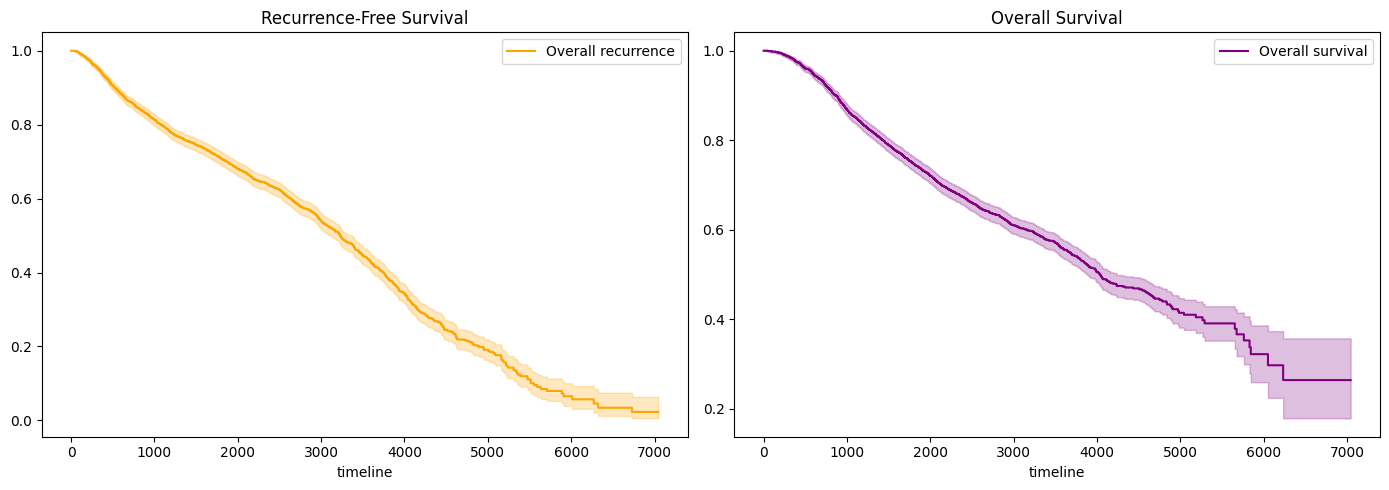

In [ ]:
kmf = KaplanMeierFitter()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

kmf.fit(
    durations=df['rtime'],
    event_observed=df['recur'],
    label = 'Overall recurrence'
)
kmf.plot_survival_function(ax=ax1, color='orange')

kmf.fit(
    durations=df['dtime'],
    event_observed=df['death'],
    label = 'Overall survival'
)
kmf.plot_survival_function(ax=ax2, color='purple')

ax1.set_title('Recurrence-Free Survival')
ax2.set_title('Overall Survival')
plt.tight_layout()

In [ ]:
print(df['age'].quantile([0.25, 0.5, 0.75]))

0.25   45.00
0.50   54.00
0.75   65.00
Name: age, dtype: float64


In [ ]:
# categorize ER and PGR into binary groups (0: <10, 1: >=10)
df['er_cat'] = np.where(df['er'] >= 10, 1, 0)
df['pgr_cat'] = np.where(df['pgr'] >= 10, 1, 0)

node_bins = [-0.1, 0, 3, 9, np.inf]
node_labels = ['0', '1-3', '4-9', '10+']
df['nodes_cat'] = pd.cut(df['nodes'], bins=node_bins, labels=node_labels, right=True)

df['age_bin'] = pd.cut(df['age'], bins=[45, 54, 64, 1000], labels=['<45', '45-64', '>64'])

num_features = ['grade', 'age'] 
cat_features = ['er_cat', 'pgr_cat', 'chemo', 'hormon', 'size', 'nodes_cat', 'age_bin']

df_clean = df.copy()

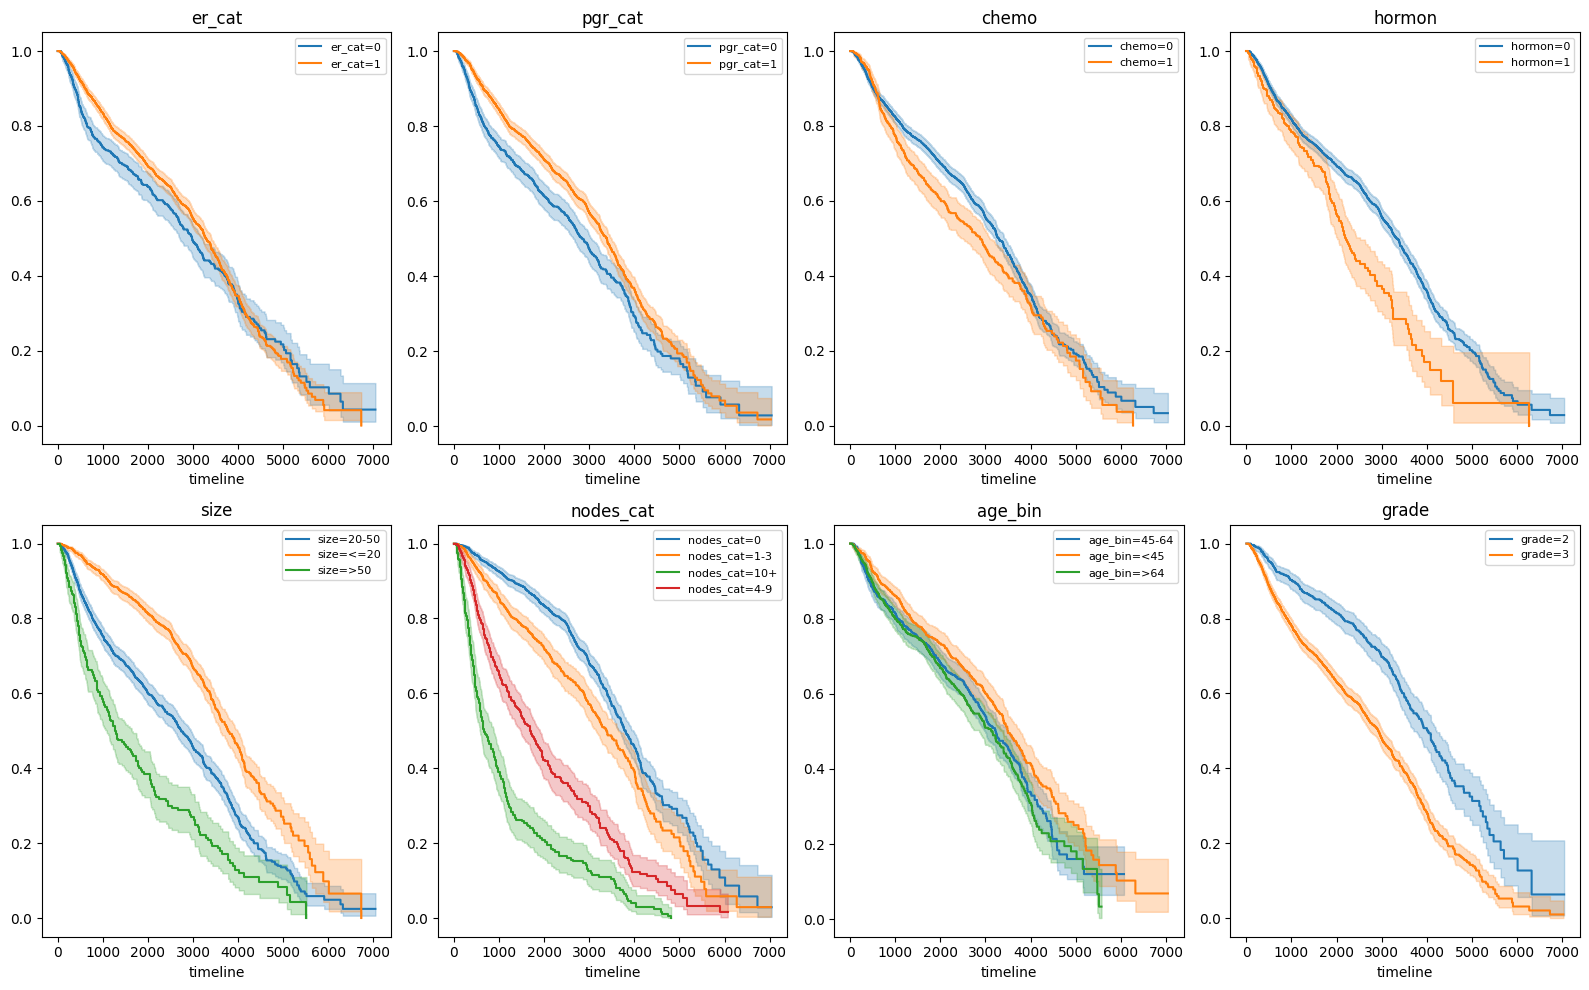

In [ ]:
# Create a grid of subplots for all covariates
fig, axes = plt.subplots(2, 4, figsize=(16, 10))
axes = axes.flatten()

for idx, covariate in enumerate(cat_features + ['grade']):
    # Ensure only non-NaN unique values are sorted to avoid TypeError
    covariate_values = np.sort(df_clean[covariate].dropna().unique())

    for value in covariate_values:
        mask = df_clean[covariate] == value
        kmf.fit(
            df_clean.loc[mask, 'rtime'],
            event_observed=df_clean.loc[mask, 'recur'],
            label=f'{covariate}={value}'
        )
        kmf.plot_survival_function(ax=axes[idx])

    axes[idx].set_title(f'{covariate}')
    axes[idx].legend(fontsize=8)

plt.tight_layout()
plt.show()

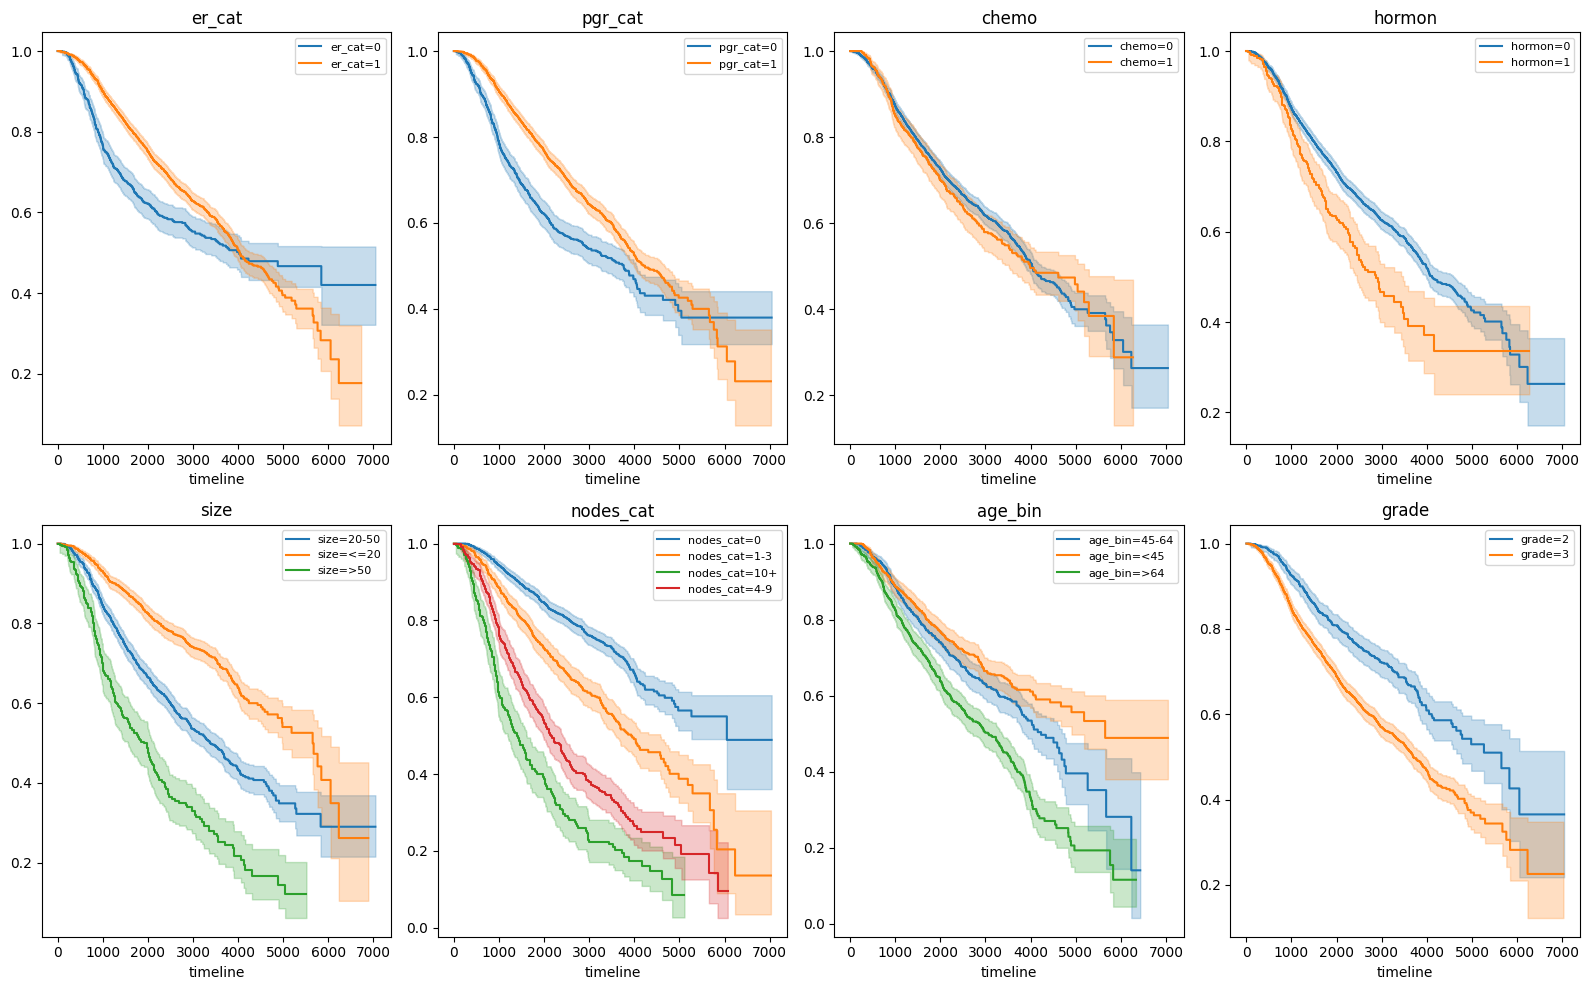

In [ ]:
# Create a grid of subplots for all covariates
fig, axes = plt.subplots(2, 4, figsize=(16, 10))
axes = axes.flatten()

for idx, covariate in enumerate(cat_features + ['grade']):
    # Ensure only non-NaN unique values are sorted to avoid TypeError
    covariate_values = np.sort(df_clean[covariate].dropna().unique())

    for value in covariate_values:
        mask = df_clean[covariate] == value
        kmf.fit(
            df_clean.loc[mask, 'dtime'],
            event_observed=df_clean.loc[mask, 'death'],
            label=f'{covariate}={value}'
        )
        kmf.plot_survival_function(ax=axes[idx])

    axes[idx].set_title(f'{covariate}')
    axes[idx].legend(fontsize=8)

plt.tight_layout()
plt.show()

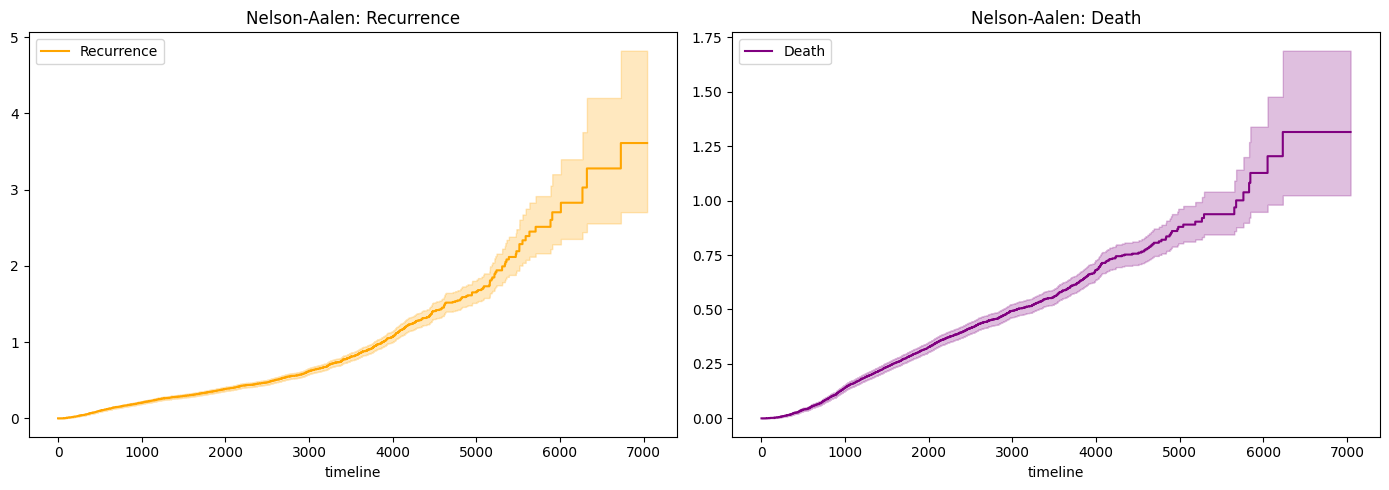

In [ ]:
naf = NelsonAalenFitter()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

naf.fit(df['rtime'], event_observed=df['recur'], label='Recurrence')
naf.plot_cumulative_hazard(ax=ax1, color='orange')
ax1.set_title('Nelson-Aalen: Recurrence')

naf.fit(df['dtime'], event_observed=df['death'], label='Death')
naf.plot_cumulative_hazard(ax=ax2, color='purple')
ax2.set_title('Nelson-Aalen: Death')

plt.tight_layout()
plt.show()

In [ ]:
from lifelines import CoxPHFitter
# Check if 'age_bin' exists in cat_features before attempting to remove it

df_clean_rfs=df_clean[cat_features + num_features + ['rtime', 'recur']]
df_clean_rfs=df_clean_rfs.dropna() # Drop rows with NaN values

# Identify categorical columns that need one-hot encoding
categorical_cols_to_encode = ['size', 'nodes_cat', 'hormon', 'chemo', 'pgr_cat', 'er_cat', 'age_bin']

scaler = StandardScaler()
df_clean_rfs['grade'] = scaler.fit_transform(df_clean_rfs[['grade']])

# One-hot encode these categorical columns
df_clean_rfs = pd.get_dummies(df_clean_rfs, columns=categorical_cols_to_encode, prefix=categorical_cols_to_encode, drop_first=True, dtype=int)

In [ ]:
df_clean_os=df_clean[cat_features + num_features + ['dtime', 'death']]
df_clean_os=df_clean_os.dropna() # Drop rows with NaN values

# Identify categorical columns that need one-hot encoding
categorical_cols_to_encode = ['size', 'nodes_cat', 'hormon', 'chemo', 'pgr_cat', 'er_cat', 'age_bin']

scaler = StandardScaler()
df_clean_os['grade'] = scaler.fit_transform(df_clean_os[['grade']])

# One-hot encode these categorical columns
df_clean_os = pd.get_dummies(df_clean_os, columns=categorical_cols_to_encode, prefix=categorical_cols_to_encode, drop_first=True, dtype=int)

# Cox model

## First model with every variable

In [ ]:
# Overall survival (time to death/censoring)
df_clean_os = df_clean_os.reset_index(drop=True)
cph_rfs = CoxPHFitter()
cph_rfs.fit(df_clean_rfs, duration_col="rtime", event_col="recur")
cph_rfs.print_summary()

<lifelines.CoxPHFitter: fitted with 2199 total observations, 1161 right-censored observations>
             duration col = 'rtime'
                event col = 'recur'
      baseline estimation = breslow
   number of observations = 2199
number of events observed = 1038
   partial log-likelihood = -6776.41
         time fit was run = 2026-02-04 11:25:04 UTC

---
               coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                      
grade          0.22      1.25      0.04            0.15            0.29                1.16                1.34
age            0.00      1.00      0.01           -0.02            0.02                0.98                1.02
size_<=20     -0.33      0.72      0.07           -0.47           -0.19                0.62                0.83
size_>50       0.30      1.35      0.09            0.12            0.48                1.13                1.62
nodes_cat_1-3  0.47      1.60      0.09            0.28            0.66                1.33                1.93
nodes_cat_4-9  1.14      3.14      0.10            0.95            1.33                2.60                3.79
nodes_cat_10+  1.76      5.81      0.11            1.55            1.97                4.73                7.14
hormon_1      -0.14      0.87      0.09           -0.32            0.04                0.73                1.04
chemo_1       -0.42      0.66      0.11           -0.64           -0.20                0.53                0.82
pgr_cat_1     -0.19      0.83      0.08           -0.34           -0.04                0.71                0.96
er_cat_1       0.10      1.11      0.09           -0.07            0.28                0.93                1.32
age_bin_45-64 -0.00      1.00      0.12           -0.23            0.23                0.79                1.25
age_bin_>64   -0.14      0.87      0.20           -0.53            0.26                0.59                1.30

               cmp to     z      p  -log2(p)
covariate                                   
grade            0.00  6.20 <0.005     30.73
age              0.00  0.21   0.83      0.26
size_<=20        0.00 -4.53 <0.005     17.36
size_>50         0.00  3.23 <0.005      9.67
nodes_cat_1-3    0.00  4.96 <0.005     20.42
nodes_cat_4-9    0.00 11.88 <0.005    105.75
nodes_cat_10+    0.00 16.74 <0.005    206.50
hormon_1         0.00 -1.50   0.13      2.89
chemo_1          0.00 -3.72 <0.005     12.30
pgr_cat_1        0.00 -2.46   0.01      6.18
er_cat_1         0.00  1.19   0.24      2.09
age_bin_45-64    0.00 -0.03   0.97      0.04
age_bin_>64      0.00 -0.67   0.50      1.00
---
Concordance = 0.74
Partial AIC = 13578.82
log-likelihood ratio test = 581.65 on 13 df
-log2(p) of ll-ratio test = 382.70

In [ ]:
# Overall survival (time to death/censoring)
df_clean_os = df_clean_os.reset_index(drop=True)
cph_os = CoxPHFitter()
cph_os.fit(df_clean_os, duration_col="dtime", event_col="death")
cph_os.print_summary()

<lifelines.CoxPHFitter: fitted with 2199 total observations, 1232 right-censored observations>
             duration col = 'dtime'
                event col = 'death'
      baseline estimation = breslow
   number of observations = 2199
number of events observed = 967
   partial log-likelihood = -6655.65
         time fit was run = 2026-02-04 11:25:10 UTC

---
               coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                      
grade          0.15      1.16      0.04            0.08            0.22                1.08                1.24
age            0.04      1.04      0.01            0.03            0.06                1.03                1.06
size_<=20     -0.30      0.74      0.08           -0.45           -0.15                0.64                0.86
size_>50       0.32      1.37      0.09            0.14            0.49                1.15                1.64
nodes_cat_1-3  0.73      2.08      0.10            0.55            0.92                1.73                2.51
nodes_cat_4-9  1.21      3.34      0.10            1.02            1.39                2.77                4.03
nodes_cat_10+  1.53      4.63      0.11            1.31            1.75                3.72                5.76
hormon_1      -0.27      0.76      0.09           -0.46           -0.09                0.63                0.91
chemo_1       -0.27      0.76      0.12           -0.51           -0.04                0.60                0.96
pgr_cat_1     -0.30      0.74      0.08           -0.46           -0.14                0.63                0.87
er_cat_1      -0.09      0.92      0.09           -0.27            0.09                0.77                1.09
age_bin_45-64 -0.35      0.70      0.12           -0.59           -0.11                0.55                0.90
age_bin_>64   -0.49      0.61      0.20           -0.88           -0.10                0.41                0.91

               cmp to     z      p  -log2(p)
covariate                                   
grade            0.00  4.12 <0.005     14.68
age              0.00  5.08 <0.005     21.37
size_<=20        0.00 -3.92 <0.005     13.48
size_>50         0.00  3.47 <0.005     10.89
nodes_cat_1-3    0.00  7.68 <0.005     45.84
nodes_cat_4-9    0.00 12.55 <0.005    117.65
nodes_cat_10+    0.00 13.70 <0.005    139.42
hormon_1         0.00 -2.91 <0.005      8.12
chemo_1          0.00 -2.26   0.02      5.37
pgr_cat_1        0.00 -3.75 <0.005     12.47
er_cat_1         0.00 -0.97   0.33      1.58
age_bin_45-64    0.00 -2.84 <0.005      7.81
age_bin_>64      0.00 -2.45   0.01      6.12
---
Concordance = 0.72
Partial AIC = 13337.30
log-likelihood ratio test = 548.15 on 13 df
-log2(p) of ll-ratio test = 359.00

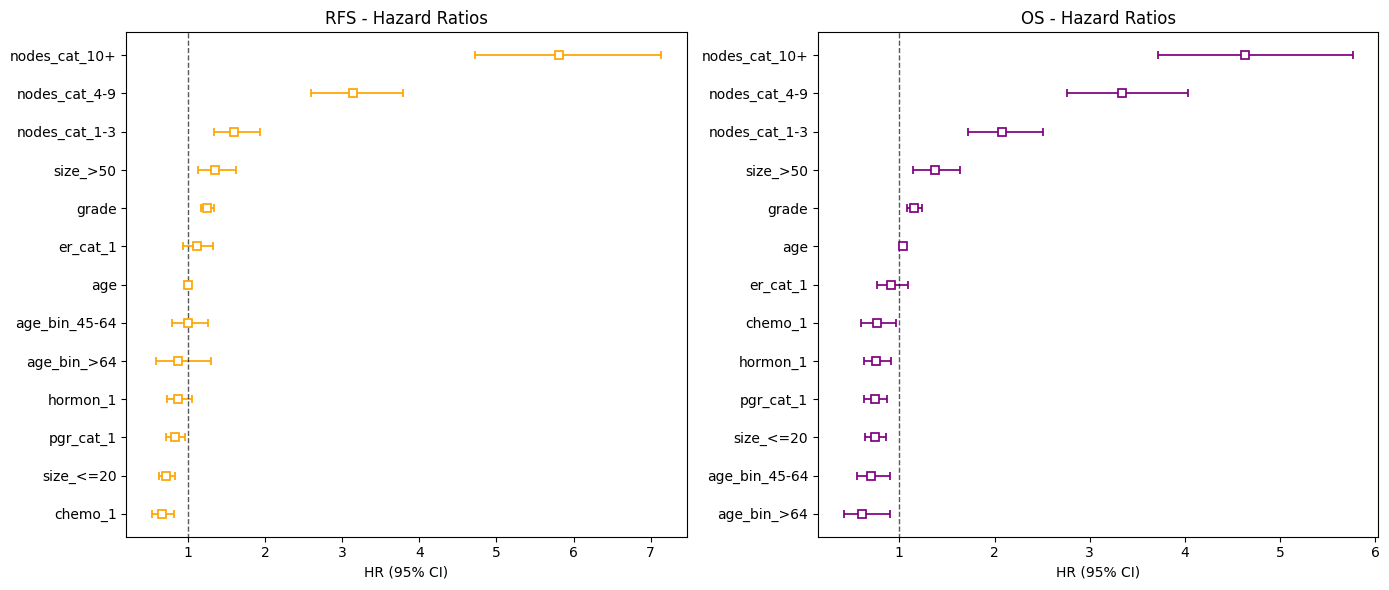

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

cph_rfs.plot(hazard_ratios=True, ax=ax1, c='orange')
ax1.set_title('RFS - Hazard Ratios')

cph_os.plot(hazard_ratios=True, ax=ax2, c='purple')
ax2.set_title('OS - Hazard Ratios')

plt.tight_layout()
plt.show()

### Cross-validation

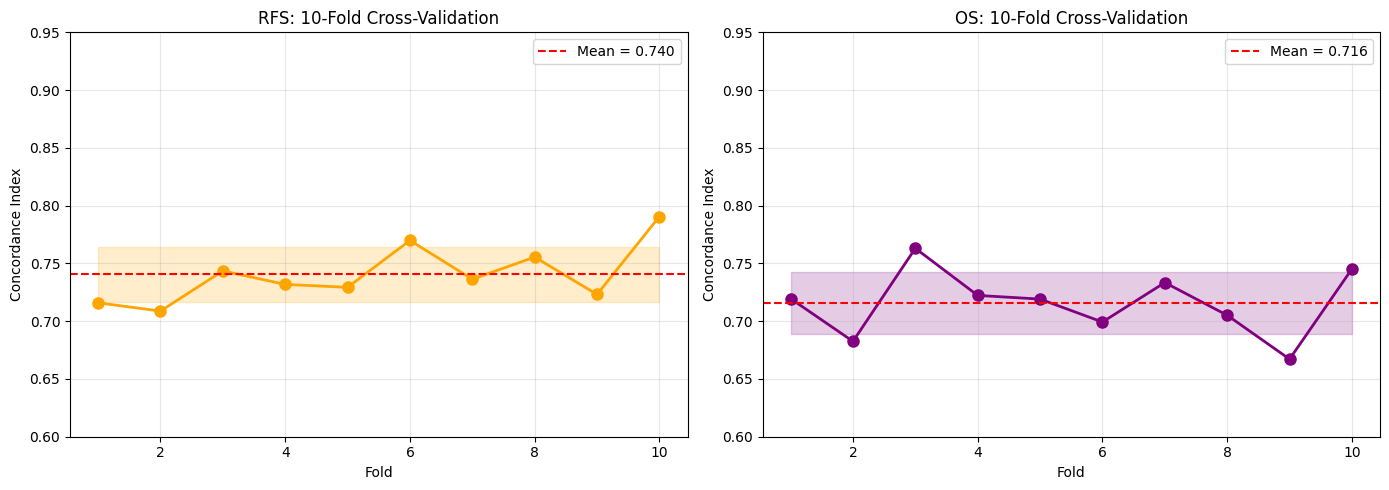


RFS C-index: mean=0.740, sd=0.024
OS C-index: mean=0.716, sd=0.027


In [ ]:
# Perform cross-validation for RFS (recurrence)
scores = k_fold_cross_validation(
    cph_rfs,
    df_clean_rfs,
    'rtime',
    event_col='recur',
    k=10,
    scoring_method="concordance_index",
    seed=1234
)

# Visualize cross-validation scores for RFS
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(range(1, len(scores) + 1), scores, marker='o', linestyle='-', color='orange', linewidth=2, markersize=8)
ax1.axhline(y=np.mean(scores), color='red', linestyle='--', label=f'Mean = {np.mean(scores):.3f}')
ax1.fill_between(range(1, len(scores) + 1),
                  np.mean(scores) - np.std(scores),
                  np.mean(scores) + np.std(scores),
                  alpha=0.2, color='orange')
ax1.set_xlabel('Fold')
ax1.set_ylabel('Concordance Index')
ax1.set_title('RFS: 10-Fold Cross-Validation')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_ylim([0.6, 0.95]) # Adjusted y-axis limit

# Perform cross-validation for OS (death)
scores_os = k_fold_cross_validation(
    cph_os,
    df_clean_os,
    'dtime',
    event_col='death',
    k=10,
    scoring_method="concordance_index",
    seed=1234
)

ax2.plot(range(1, len(scores_os) + 1), scores_os, marker='o', linestyle='-', color='purple', linewidth=2, markersize=8)
ax2.axhline(y=np.mean(scores_os), color='red', linestyle='--', label=f'Mean = {np.mean(scores_os):.3f}')
ax2.fill_between(range(1, len(scores_os) + 1),
                  np.mean(scores_os) - np.std(scores_os),
                  np.mean(scores_os) + np.std(scores_os),
                  alpha=0.2, color='purple')
ax2.set_xlabel('Fold')
ax2.set_ylabel('Concordance Index')
ax2.set_title('OS: 10-Fold Cross-Validation')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_ylim([0.6, 0.95]) # Adjusted y-axis limit

plt.tight_layout()
plt.show()

print(f"\nRFS C-index: mean={np.mean(scores):.3f}, sd={np.std(scores):.3f}")
print(f"OS C-index: mean={np.mean(scores_os):.3f}, sd={np.std(scores_os):.3f}")

## Forward, Backward and Best subset selection

In [ ]:
# Prepare data excluding age_bin
cat_features_no_age_bin = [f for f in cat_features if f != 'age_bin']
df_clean_rfs = df_clean[cat_features_no_age_bin + num_features + ['rtime', 'recur']]
df_clean_rfs = df_clean_rfs.dropna()

df_clean_os = df_clean[cat_features_no_age_bin + num_features + ['dtime', 'death']]
df_clean_os = df_clean_os.dropna()

# Categorical columns to one-hot encode
categorical_cols_to_encode = ['size', 'nodes_cat', 'hormon', 'chemo', 'pgr_cat', 'er_cat']

# Scale numerical features
scaler = StandardScaler()
df_clean_rfs['grade'] = scaler.fit_transform(df_clean_rfs[['grade']])
df_clean_rfs['age'] = scaler.fit_transform(df_clean_rfs[['age']])

df_clean_os['grade'] = scaler.fit_transform(df_clean_os[['grade']])
df_clean_os['age'] = scaler.fit_transform(df_clean_os[['age']])

# One-hot encode categorical columns
df_clean_rfs = pd.get_dummies(df_clean_rfs, columns=categorical_cols_to_encode, prefix=categorical_cols_to_encode, drop_first=True, dtype=int)
df_clean_os = pd.get_dummies(df_clean_os, columns=categorical_cols_to_encode, prefix=categorical_cols_to_encode, drop_first=True, dtype=int)

In [ ]:
from sklearn.model_selection import KFold

cv = KFold(n_splits=5, shuffle=True, random_state=42)
cox_rfs = CoxPHFitter()
cox_rfs.fit(df_clean_rfs, duration_col='rtime', event_col='recur')
cox_os = CoxPHFitter()
cox_os.fit(df_clean_os, duration_col='dtime', event_col='death')

<lifelines.CoxPHFitter: fitted with 2982 total observations, 1710 right-censored observations>

## Forward selection

In [35]:
# Prepare features and target for RFS
X_rfs = df_clean_rfs.drop(['rtime', 'recur'], axis=1)
y_rfs = df_clean_rfs[['rtime', 'recur']]

# Manual forward selection using k_fold_cross_validation
selected_features_rfs = []
remaining_features = X_rfs.columns.tolist()
best_score = -np.inf
rfs_forward_metrics = []

while remaining_features:
    best_feature = None
    best_cv_score = -np.inf
    
    for feature in remaining_features:
        current_features = selected_features_rfs + [feature]
        df_subset = df_clean_rfs[current_features + ['rtime', 'recur']]
        
        cv_scores = k_fold_cross_validation(
            CoxPHFitter(),
            df_subset,
            'rtime',
            event_col='recur',
            k=5,
            scoring_method="concordance_index",
            seed=1234
        )
        
        mean_score = np.mean(cv_scores)
        if mean_score > best_cv_score:
            best_cv_score = mean_score
            best_feature = feature
    
    if best_cv_score > best_score:
        selected_features_rfs.append(best_feature)
        remaining_features.remove(best_feature)
        best_score = best_cv_score
        rfs_forward_metrics.append({
            "feature": best_feature,
            "n_features": len(selected_features_rfs),
            "c_index": best_score,
            "features": selected_features_rfs.copy()
        })
    else:
        break

selected_forward_rfs = selected_features_rfs
print(f"Final selected features (RFS): {selected_forward_rfs}\n")

# Print metrics table for RFS forward selection
rfs_forward_df = pd.DataFrame(rfs_forward_metrics)
rfs_forward_df

Final selected features (RFS): ['size_<=20', 'nodes_cat_10+', 'nodes_cat_4-9', 'grade', 'nodes_cat_1-3', 'age', 'chemo_1', 'hormon_1', 'pgr_cat_1', 'size_>50']



,feature,n_features,c_index,features
0,size_<=20,1,0.61,[size_<=20]
1,nodes_cat_10+,2,0.66,"[size_<=20, nodes_cat_10+]"
2,nodes_cat_4-9,3,0.70,"[size_<=20, nodes_cat_10+, nodes_cat_4-9]"
3,grade,4,0.71,"[size_<=20, nodes_cat_10+, nodes_cat_4-9, grade]"
4,nodes_cat_1-3,5,0.72,"[size_<=20, nodes_cat_10+, nodes_cat_4-9, grad..."
5,age,6,0.72,"[size_<=20, nodes_cat_10+, nodes_cat_4-9, grad..."
6,chemo_1,7,0.72,"[size_<=20, nodes_cat_10+, nodes_cat_4-9, grad..."
7,hormon_1,8,0.73,"[size_<=20, nodes_cat_10+, nodes_cat_4-9, grad..."
8,pgr_cat_1,9,0.73,"[size_<=20, nodes_cat_10+, nodes_cat_4-9, grad..."
9,size_>50,10,0.73,"[size_<=20, nodes_cat_10+, nodes_cat_4-9, grad..."


In [36]:
# Prepare features and target for OS
X_os = df_clean_os.drop(['dtime', 'death'], axis=1)
y_os = df_clean_os[['dtime', 'death']]

# Manual forward selection using k_fold_cross_validation
selected_features_os = []
remaining_features = X_os.columns.tolist()
best_score = -np.inf
os_forward_metrics = []

while remaining_features:
    best_feature = None
    best_cv_score = -np.inf
    
    for feature in remaining_features:
        current_features = selected_features_os + [feature]
        df_subset = df_clean_os[current_features + ['dtime', 'death']]
        
        cv_scores = k_fold_cross_validation(
            CoxPHFitter(),
            df_subset,
            'dtime',
            event_col='death',
            k=5,
            scoring_method="concordance_index",
            seed=1234
        )
        
        mean_score = np.mean(cv_scores)
        if mean_score > best_cv_score:
            best_cv_score = mean_score
            best_feature = feature
    
    if best_cv_score > best_score:
        selected_features_os.append(best_feature)
        remaining_features.remove(best_feature)
        best_score = best_cv_score
        os_forward_metrics.append({
            "feature": best_feature,
            "n_features": len(selected_features_os),
            "c_index": best_score,
            "features": selected_features_os.copy()
        })
    else:
        break

selected_forward_os = selected_features_os
print(f"Final selected features (OS): {selected_forward_os}\n")

# Print metrics table for OS forward selection
os_forward_df = pd.DataFrame(os_forward_metrics)
os_forward_df

Final selected features (OS): ['size_<=20', 'nodes_cat_10+', 'nodes_cat_4-9', 'pgr_cat_1', 'nodes_cat_1-3', 'grade', 'age', 'hormon_1', 'chemo_1', 'size_>50', 'er_cat_1']



,feature,n_features,c_index,features
0,size_<=20,1,0.60,[size_<=20]
1,nodes_cat_10+,2,0.64,"[size_<=20, nodes_cat_10+]"
2,nodes_cat_4-9,3,0.67,"[size_<=20, nodes_cat_10+, nodes_cat_4-9]"
3,pgr_cat_1,4,0.68,"[size_<=20, nodes_cat_10+, nodes_cat_4-9, pgr_..."
4,nodes_cat_1-3,5,0.69,"[size_<=20, nodes_cat_10+, nodes_cat_4-9, pgr_..."
5,grade,6,0.70,"[size_<=20, nodes_cat_10+, nodes_cat_4-9, pgr_..."
6,age,7,0.70,"[size_<=20, nodes_cat_10+, nodes_cat_4-9, pgr_..."
7,hormon_1,8,0.70,"[size_<=20, nodes_cat_10+, nodes_cat_4-9, pgr_..."
8,chemo_1,9,0.70,"[size_<=20, nodes_cat_10+, nodes_cat_4-9, pgr_..."
9,size_>50,10,0.70,"[size_<=20, nodes_cat_10+, nodes_cat_4-9, pgr_..."


### Backward

In [37]:
# Manual backward selection for RFS
selected_features_rfs = X_rfs.columns.tolist()
best_score = -np.inf
rfs_backward_metrics = []

while len(selected_features_rfs) > 1:
    worst_feature = None
    worst_feature_score = np.inf
    
    for feature in selected_features_rfs:
        remaining_rfs = [f for f in selected_features_rfs if f != feature]
        df_subset = df_clean_rfs[remaining_rfs + ['rtime', 'recur']]
        
        cv_scores = k_fold_cross_validation(
            CoxPHFitter(),
            df_subset,
            'rtime',
            event_col='recur',
            k=5,
            scoring_method="concordance_index",
            seed=1234
        )
        
        mean_score = np.mean(cv_scores)
        if mean_score < worst_feature_score:
            worst_feature_score = mean_score
            worst_feature = feature
    
    # If removing worst feature improves or maintains score, remove it
    if worst_feature_score >= best_score:
        selected_features_rfs.remove(worst_feature)
        best_score = worst_feature_score
        rfs_backward_metrics.append({
            "feature": worst_feature,
            "n_features": len(selected_features_rfs),
            "c_index": best_score,
            "features": selected_features_rfs.copy()
        })
    else:
        break

selected_backward_rfs = selected_features_rfs
print(f"Final selected features (RFS): {selected_backward_rfs}\n")

# Print metrics table for RFS backward selection
rfs_backward_df = pd.DataFrame(rfs_backward_metrics)
rfs_backward_df

Final selected features (RFS): ['grade', 'age', 'size_<=20', 'size_>50', 'nodes_cat_1-3', 'nodes_cat_4-9', 'hormon_1', 'chemo_1', 'pgr_cat_1', 'er_cat_1']



,feature,n_features,c_index,features
0,nodes_cat_10+,10,0.67,"[grade, age, size_<=20, size_>50, nodes_cat_1-..."


In [38]:
# Manual backward selection for OS
selected_features_os = X_os.columns.tolist()
best_score = -np.inf
os_backward_metrics = []

while len(selected_features_os) > 1:
    worst_feature = None
    worst_feature_score = np.inf
    
    for feature in selected_features_os:
        remaining_os = [f for f in selected_features_os if f != feature]
        df_subset = df_clean_os[remaining_os + ['dtime', 'death']]
        
        cv_scores = k_fold_cross_validation(
            CoxPHFitter(),
            df_subset,
            'dtime',
            event_col='death',
            k=5,
            scoring_method="concordance_index",
            seed=1234
        )
        
        mean_score = np.mean(cv_scores)
        if mean_score < worst_feature_score:
            worst_feature_score = mean_score
            worst_feature = feature
    
    # If removing worst feature improves or maintains score, remove it
    if worst_feature_score >= best_score:
        selected_features_os.remove(worst_feature)
        best_score = worst_feature_score
        os_backward_metrics.append({
            "feature": worst_feature,
            "n_features": len(selected_features_os),
            "c_index": best_score,
            "features": selected_features_os.copy()
        })
    else:
        break

selected_backward_os = selected_features_os
print(f"Final selected features (OS): {selected_backward_os}\n")

# Print metrics table for OS backward selection
os_backward_df = pd.DataFrame(os_backward_metrics)
os_backward_df

Final selected features (OS): ['grade', 'age', 'size_<=20', 'size_>50', 'nodes_cat_1-3', 'nodes_cat_4-9', 'hormon_1', 'chemo_1', 'pgr_cat_1', 'er_cat_1']



,feature,n_features,c_index,features
0,nodes_cat_10+,10,0.67,"[grade, age, size_<=20, size_>50, nodes_cat_1-..."


### Best subset

In [39]:
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS

print("=" * 80)
print("RFS - BEST SUBSET SELECTION (Exhaustive Feature Selection)")
print("=" * 80)
print(f"Testing all possible feature combinations from 2 to {len(X_rfs.columns)} features\n")

# Capture metrics for each evaluated subset
rfs_metrics = []
rfs_iteration = [0]

def score_and_capture_rfs(estimator, X_subset, y_subset):
    estimator.fit(X_subset, y_subset)
    score = estimator.concordance_index_
    rfs_iteration[0] += 1
    rfs_metrics.append({
        "iteration": rfs_iteration[0],
        "n_features": X_subset.shape[1],
        "c_index": score,
        "features": list(X_subset.columns)
    })
    return score

efs_rfs = EFS(
    estimator=cox_rfs,
    min_features=2,
    max_features=len(X_rfs.columns),
    scoring=score_and_capture_rfs,
    cv=cv,
    print_progress=True,
)

print("Starting exhaustive search for RFS...\n")
efs_rfs = efs_rfs.fit(X_rfs, y_rfs)

best_idx_rfs = list(efs_rfs.best_idx_)
best_subset_rfs = [X_rfs.columns[i] for i in best_idx_rfs]

print(f"\n{'=' * 80}")
print(f"RFS - Best subset: {best_subset_rfs}")
print(f"RFS - Best CV c-index: {efs_rfs.best_score_:.4f}")
print(f"Number of features selected: {len(best_subset_rfs)}")
print(f"{'=' * 80}\n")

# Print metrics table for RFS at the end
rfs_metrics_df = pd.DataFrame(rfs_metrics)
print("RFS - Exhaustive Search Metrics (all iterations)")
print(rfs_metrics_df.to_string(index=False))
print()

# Repeat for OS
print("=" * 80)
print("OS - BEST SUBSET SELECTION (Exhaustive Feature Selection)")
print("=" * 80)
print(f"Testing all possible feature combinations from 2 to {len(X_os.columns)} features\n")

os_metrics = []
os_iteration = [0]

def score_and_capture_os(estimator, X_subset, y_subset):
    estimator.fit(X_subset, y_subset)
    score = estimator.concordance_index_
    os_iteration[0] += 1
    os_metrics.append({
        "iteration": os_iteration[0],
        "n_features": X_subset.shape[1],
        "c_index": score,
        "features": list(X_subset.columns)
    })
    return score

efs_os = EFS(
    estimator=cox_os,
    min_features=2,
    max_features=len(X_os.columns),
    scoring=score_and_capture_os,
    cv=cv,
    print_progress=True,
)

print("Starting exhaustive search for OS...\n")
efs_os = efs_os.fit(X_os, y_os)

best_idx_os = list(efs_os.best_idx_)
best_subset_os = [X_os.columns[i] for i in best_idx_os]

print(f"\n{'=' * 80}")
print(f"OS - Best subset: {best_subset_os}")
print(f"OS - Best CV c-index: {efs_os.best_score_:.4f}")
print(f"Number of features selected: {len(best_subset_os)}")
print(f"{'=' * 80}\n")

# Print metrics table for OS at the end
os_metrics_df = pd.DataFrame(os_metrics)
print("OS - Exhaustive Search Metrics (all iterations)")
print(os_metrics_df.to_string(index=False))
print()

RFS - BEST SUBSET SELECTION (Exhaustive Feature Selection)
Testing all possible feature combinations from 2 to 11 features



RFS - BEST SUBSET SELECTION (Exhaustive Feature Selection)
Testing all possible feature combinations from 2 to 11 features



TypeError: Cannot clone object '<lifelines.CoxPHFitter: fitted with 2982 total observations, 1509 right-censored observations>' (type <class 'lifelines.fitters.coxph_fitter.CoxPHFitter'>): it does not seem to be a scikit-learn estimator as it does not implement a 'get_params' method.

## Model with selected variables + cross validation

In [ ]:
df_forward_rfs = df_clean_rfs[['size_ord', 'grade', 'pgr_cat', 'nodes_ord', 'rtime', 'recur']]
df_forward_os = df_clean_os[['size_ord', 'grade', 'pgr_cat', 'nodes_ord', 'dtime', 'death']]

df_backward_rfs = df_clean_rfs[['size_ord', 'grade', 'pgr_cat', 'nodes_ord', 'rtime', 'recur']]
df_backward_os = df_clean_os[['size_ord', 'grade', 'pgr_cat', 'nodes_ord', 'dtime', 'death']]

df_best_rfs = df_clean_rfs[['age_bin', 'size_ord', 'grade', 'pgr_cat', 'nodes_ord', 'hormon', 'chemo', 'rtime', 'recur']]
df_best_os = df_clean_os[['age_bin', 'size_ord', 'grade', 'er_cat', 'pgr_cat', 'nodes_ord', 'hormon', 'chemo', 'dtime', 'death']]

### Forward

In [ ]:
cph_forward_rfs = CoxPHFitter()
cph_forward_rfs.fit(df_forward_rfs, duration_col = 'rtime', event_col = 'recur')
cph_forward_rfs.print_summary()

In [ ]:
cph_forward_os = CoxPHFitter()
cph_forward_os.fit(df_forward_os, duration_col = 'dtime', event_col = 'death')
cph_forward_os.print_summary()

In [ ]:
features_forward_rfs = df_forward_rfs.columns.to_list().copy()
scores_forward_rfs = k_fold_cross_validation(cph_forward_rfs, df_forward_rfs[features_forward_rfs], 'rtime', event_col='recur', k=10, scoring_method="concordance_index", seed=1234)
scores_forward_rfs

print("RFS -", np.mean(scores_forward_rfs), np.std(scores_forward_rfs))

features_forward_os = df_clean_os.columns.to_list().copy()
scores_forward_os = k_fold_cross_validation(cph_os, df_clean_os[features_forward_os], 'dtime', event_col='death', k=10, scoring_method="concordance_index", seed=1234)
scores_forward_os

print("OS -", np.mean(scores_forward_os), np.std(scores_forward_os))

### Backward

In [ ]:
cph_backward_rfs = CoxPHFitter()
cph_backward_rfs.fit(df_backward_rfs, duration_col = 'rtime', event_col = 'recur')
cph_backward_rfs.print_summary()

In [ ]:
cph_backward_os = CoxPHFitter()
cph_backward_os.fit(df_backward_os, duration_col = 'dtime', event_col = 'death')
cph_backward_os.print_summary()

In [ ]:
features_backward_rfs = df_backward_rfs.columns.to_list().copy()
scores_backward_rfs = k_fold_cross_validation(cph_backward_rfs, df_backward_rfs[features_backward_rfs], 'rtime', event_col='recur', k=10, scoring_method="concordance_index", seed=1234)
scores_backward_rfs

print("RFS -", np.mean(scores_backward_rfs), np.std(scores_backward_rfs))

features_backward_os = df_clean_os.columns.to_list().copy()
scores_backward_os = k_fold_cross_validation(cph_os, df_clean_os[features_backward_os], 'dtime', event_col='death', k=10, scoring_method="concordance_index", seed=1234)
scores_backward_os

print("OS -", np.mean(scores_backward_os), np.std(scores_backward_os))

### Best subset

In [ ]:
cph_best_rfs = CoxPHFitter()
cph_best_rfs.fit(df_best_rfs, duration_col = 'rtime', event_col = 'recur')
cph_best_rfs.print_summary()

In [ ]:
cph_best_os = CoxPHFitter()
cph_best_os.fit(df_best_os, duration_col = 'dtime', event_col = 'death')
cph_best_os.print_summary()

In [ ]:
features_best_rfs = df_best_rfs.columns.to_list().copy()
scores_best_rfs = k_fold_cross_validation(cph_best_rfs, df_best_rfs[features_best_rfs], 'rtime', event_col='recur', k=10, scoring_method="concordance_index", seed=1234)
scores_best_rfs

print("RFS -", np.mean(scores_best_rfs), np.std(scores_best_rfs))

features_best_os = df_clean_os.columns.to_list().copy()
scores_best_os = k_fold_cross_validation(cph_os, df_clean_os[features_best_os], 'dtime', event_col='death', k=10, scoring_method="concordance_index", seed=1234)
scores_best_os

print("OS -", np.mean(scores_best_os), np.std(scores_best_os))

## Penalization

In [ ]:
cph_rfs_penalized = CoxPHFitter(penalizer=0.1, l1_ratio=1.0) # penalizer is alpha, l1_ratio is lambda in the equation above
cph_rfs_penalized.fit(df_best_rfs, duration_col = 'rtime', event_col = 'recur')
cph_rfs_penalized.print_summary()

In [ ]:
cph_rfs_penalized.plot(hazard_ratios=True)

In [ ]:
cph_os_penalized = CoxPHFitter(penalizer=0.1, l1_ratio=1.0) # penalizer is alpha, l1_ratio is lambda in the equation above
cph_os_penalized.fit(df_best_os, duration_col = 'dtime', event_col = 'death')
cph_os_penalized.print_summary()

In [ ]:
cph_os_penalized.plot(hazard_ratios=True)

### Schoenfeld's residuals and test

In [40]:
cph_best_rfs.check_assumptions(df_best_rfs, p_value_threshold = 0.05, show_plots=True)

NameError: name 'cph_best_rfs' is not defined

In [ ]:
cph_os_penalized.check_assumptions(df_best_os, p_value_threshold = 0.05, show_plots=True)

### Cross Validation

In [ ]:
features_rfs = df_best_rfs.columns.to_list().copy()
scores_rfs = k_fold_cross_validation(cph_rfs_penalized, df_best_rfs, 'rtime', event_col='recur', k=10, scoring_method="concordance_index", seed=1234)
scores_rfs

print(np.mean(scores_rfs), np.std(scores_rfs))

In [ ]:
features_os = df_best_os.columns.to_list().copy()
scores_os = k_fold_cross_validation(cph_os_penalized, df_best_os, 'dtime', event_col='death', k=10, scoring_method="concordance_index", seed=1234)
scores_os

print(np.mean(scores_os), np.std(scores_os))

## Stratify with respect to one variable

In [ ]:
cph_rfs_penalized.fit(df_best_rfs, duration_col = 'rtime', event_col = 'recur', strata=['age_bin', 'nodes_ord'])
cph_rfs_penalized.print_summary()